In [396]:
import numpy as np
from scipy.io import loadmat
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from scipy.optimize import fmin_cg

In [2]:
input_layer_size  = 400 # % 20x20 Input Images of Digits
hidden_layer_size = 25 #   % 25 hidden units
num_labels = 10

In [3]:
data = loadmat('ex4data1', mat_dtype=True)
X_orig = data['X']
m = X_orig.shape[0]
X = ((X_orig-X_orig[:].min(axis = 1).reshape(m,1))/(X_orig[:].max(axis = 1)-X_orig[:].min(axis = 1)).reshape(m,1)*255).astype(int)
y = data['y']


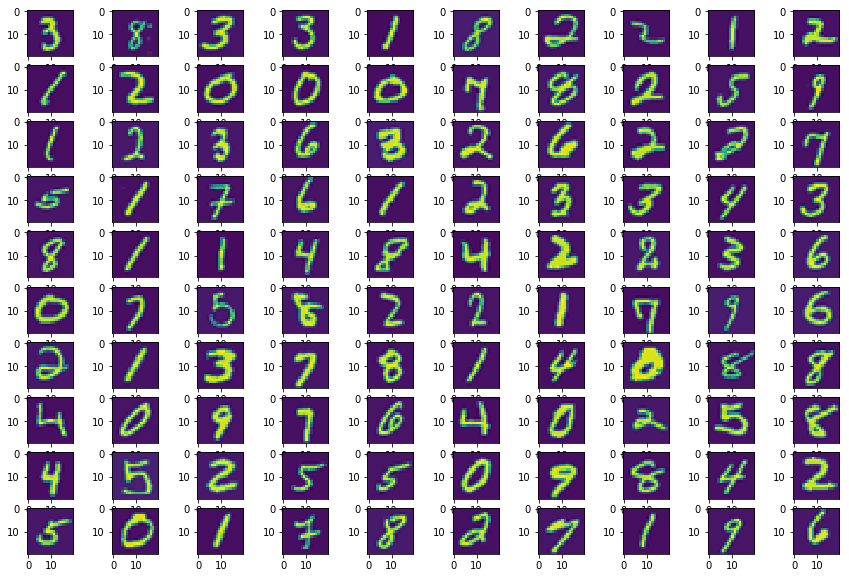

In [4]:
indicies = np.random.choice(np.arange(m), 100)

cols,rows=10,10
fig, ax  = plt.subplots(rows,cols, figsize=[15,10])
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(scipy.misc.toimage(X[indicies[i*cols+j]].reshape(20,20).T))
plt.show()

In [5]:
weights_file = loadmat('ex4weights.mat', mat_dtype=True)

In [6]:
Theta1_orig, Theta2_orig = weights_file['Theta1'], weights_file['Theta2']

In [199]:
nn_params = np.concatenate((Theta1_orig.flatten(), Theta2_orig.flatten()))

In [7]:
def sigmoid(x, theta):
    return 1/(1+np.e**-x.dot(theta))

In [8]:
def sigmoidZ(z):
    return 1/(1+np.e**-z)

In [9]:
def gradSigmoid(z):
    return sigmoidZ(z)*(1-sigmoidZ(z))

In [10]:
def epsilonOpt(L1,L2):
    return np.sqrt(6)/np.sqrt(L1+L2)

In [11]:
def randThetaInit(no_in, no_un, epsilon):
    return epsilon*(2*np.random.random((no_un, no_in))-1)

In [218]:
Theta1_init = randThetaInit(401,25,.12)
Theta2_init = randThetaInit(26,10,.12)
nn_params_init = np.concatenate((Theta1_init.flatten(), Theta2_init.flatten()))

In [405]:
def perdict(X, nn_params,input_layer_size,hidden_layer_size,num_labels):
    theta1 = nn_params[:(input_layer_size+1)*hidden_layer_size].reshape(hidden_layer_size, input_layer_size+1)
    theta2 = nn_params[-(hidden_layer_size+1)*num_labels:].reshape(num_labels, hidden_layer_size+1)
    IL = np.insert(X, 0, 1, axis=1)
    HL = sigmoid(IL, theta1.T)
    HL = np.insert(HL, 0, 1, axis=1)
    OL = sigmoid(HL, theta2.T)
    return (np.argmax((OL), axis=1) + 1).reshape(OL.shape[0],1)

In [414]:
p = perdict(X_orig, res, input_layer_size, hidden_layer_size, num_labels)

In [415]:
np.mean(p==y)

0.99439999999999995

In [16]:
encoder = OneHotEncoder()

In [17]:
y_oh = encoder.fit_transform(y).toarray()

In [18]:
def ff_nn(X, theta1, theta2):
    X_bias = np.insert(X,0,1,axis=1) #np.append(1,X, axis=1) #add axis condition
    IL = sigmoid(X_bias, theta1.T)
    IL = np.insert(IL,0,1,axis=1) # np.append(1, IL, axis=1)   #add axis condition
    OL = sigmoid(IL, theta2.T)
    return OL

In [24]:
def ff_nn_one_exmpl(X, theta1, theta2):
    X_bias = np.insert(X,0,1,axis=0) #np.append(1,X, axis=1) #add axis condition
    IL = sigmoid(X_bias, theta1.T)
    IL = np.insert(IL,0,1,axis=0) # np.append(1, IL, axis=1)   #add axis condition
    OL = sigmoid(IL, theta2.T)
    return IL, OL

In [25]:
ff_res = ff_nn(X_orig, Theta1_orig, Theta2_orig)

In [206]:
def costFunc_nUnrolled(X,y,theta1,theta2,lmbd):
    m = X.shape[0]
    predicted = ff_nn(X, theta1, theta2)
    part1 = -y*np.log(predicted)
#     print(part1)
    part2 = -(1-y)*np.log(1e-300+1-predicted)
#     print(part2)
    part3 = lmbd*((theta1[:,1:]**2).sum() + (theta2[:,1:]**2).sum())/2
#     print(((part1+part2).sum() + part3)/m)
    return ((part1+part2).sum() + part3)/m

In [400]:
def costFunc(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,lmbd,dummy):
    m = X.shape[0]
    theta1 = nn_params[:(input_layer_size+1)*hidden_layer_size].reshape(hidden_layer_size, input_layer_size+1)
    theta2 = nn_params[-(hidden_layer_size+1)*num_labels:].reshape(num_labels, hidden_layer_size+1)
    predicted = ff_nn(X, theta1, theta2)
    part1 = -y*np.log(predicted)
#     print(part1)
    part2 = -(1-y)*np.log(1e-300+1-predicted)
#     print(part2)
    part3 = lmbd*((theta1[:,1:]**2).sum() + (theta2[:,1:]**2).sum())/2
#     print(((part1+part2).sum() + part3)/m)
    return ((part1+part2).sum() + part3)/m

In [205]:
costFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X_orig, y_oh, 0)

0.28762916516131892

In [385]:
X_checking = X_orig[:100]
y_checking = y_oh[:100]

In [397]:
def grad(nn_params,input_layer_size,hidden_layer_size,num_labels, X, y,lmbd,ff_func):
    theta1 = nn_params[:(input_layer_size+1)*hidden_layer_size].reshape(hidden_layer_size, input_layer_size+1)
    theta2 = nn_params[-(hidden_layer_size+1)*num_labels:].reshape(num_labels, hidden_layer_size+1)
    m = X.shape[0]
    D1,D2 = np.zeros(theta1.shape), np.zeros(theta2.shape)
    for t in range(m):
        a2, ff_res = ff_func(X[t], theta1, theta2)
        dlt3 = ff_res-y[t]
        p = dlt3.size
        X_bias = np.insert(X[t],0,1,axis=0)
        l = X_bias.size
        z2 = theta1.dot(X_bias)
        dlt2 = theta2[:,1:].T.dot(dlt3)*sigmoidZ(z2)*(1-sigmoidZ(z2))
        s = dlt2.size
        Dlt2 = dlt3.reshape(p,1).dot(a2.reshape(1,s+1))
        Dlt1 = dlt2.reshape(s,1).dot(X_bias.reshape(1,l))
        D2 += Dlt2
        D1 += Dlt1
    D1 += lmbd * theta1
    D1 /= m
    D2 += lmbd * theta2
    D2 /= m
    return np.concatenate((D1.flatten(), D2.flatten()))

In [382]:
def gradChecking(nn_params,input_layer_size,hidden_layer_size,num_labels, X, y, lmbd, epsilon = 1e-4):
    theta1 = nn_params[:(input_layer_size+1)*hidden_layer_size].reshape(hidden_layer_size, input_layer_size+1)
    theta2 = nn_params[-(hidden_layer_size+1)*num_labels:].reshape(num_labels, hidden_layer_size+1)    
    grad_approx = np.empty(nn_params.size)
    for i in range(nn_params.size):
        theta_plus = nn_params.copy()
#         print(theta_plus[:10])
        theta_plus[i] += epsilon
#         print(theta_plus[:10])
        theta_minus = nn_params.copy()
        theta_minus[i] -= epsilon
#         print(theta_plus.sum() - theta_minus.sum())
#         print(theta_plus[i])
        grad_approx[i] = (costFunc(theta_plus,input_layer_size,hidden_layer_size,num_labels,X,y,lmbd) - costFunc(theta_minus,input_layer_size,hidden_layer_size,num_labels,X,y,lmbd))/2/epsilon
#         break
    return grad_approx

In [398]:
unrolled = grad(nn_params, input_layer_size, hidden_layer_size, num_labels, X_checking, y_checking, 1, ff_nn_one_exmpl)

In [393]:
test = gradChecking(nn_params, input_layer_size, hidden_layer_size, num_labels, X_checking, y_checking, 1, epsilon=1e-4)

In [399]:
np.concatenate((unrolled.reshape(unrolled.size,1),test.reshape(test.size,1)),axis=1)[-50:,:]

array([[ 0.01316408,  0.01316408],
       [-0.00734538, -0.00734538],
       [-0.03868459, -0.03868459],
       [ 0.0082867 ,  0.0082867 ],
       [-0.02373614, -0.02373614],
       [ 0.00822427,  0.00822427],
       [-0.01089479, -0.01089479],
       [ 0.02785976,  0.02785976],
       [ 0.0038421 ,  0.0038421 ],
       [ 0.00724751,  0.00724751],
       [-0.00884273, -0.00884273],
       [-0.00805777, -0.00805777],
       [-0.01990754, -0.01990754],
       [-0.02937943, -0.02937943],
       [ 0.00869892,  0.00869892],
       [-0.00852087, -0.00852087],
       [ 0.00766699,  0.00766699],
       [ 0.00809103,  0.00809103],
       [-0.017908  , -0.017908  ],
       [ 0.00664506,  0.00664506],
       [ 0.02076932,  0.02076932],
       [ 0.00064053,  0.00064053],
       [-0.01132833, -0.01132833],
       [-0.02092675, -0.02092675],
       [-0.05378306, -0.04917415],
       [-0.02101565, -0.02101565],
       [-0.01519479, -0.01519479],
       [-0.04119493, -0.04119493],
       [-0.03621962,

In [412]:
res = fmin_cg(costFunc, nn_params_init, fprime=grad, maxiter=50, args=(input_layer_size, hidden_layer_size, num_labels, X_orig, y_oh, 1, ff_nn_one_exmpl))

         Current function value: 0.320537
         Iterations: 400
         Function evaluations: 1011
         Gradient evaluations: 1011


In [426]:
theta1_res = res[:(input_layer_size+1)*hidden_layer_size].reshape(hidden_layer_size, input_layer_size+1)

In [424]:
p = perdict(X_orig, res, input_layer_size, hidden_layer_size, num_labels)

In [425]:
np.mean(p==y)

0.99439999999999995

In [421]:
np.concatenate((res.reshape(unrolled.size,1),nn_params.reshape(test.size,1)),axis=1)[300:400,:]

array([[ -7.60912310e-03,  -4.64033518e-03],
       [ -9.06192807e-05,  -9.03614636e-04],
       [ -6.24023463e-03,   1.03357110e-02],
       [ -8.08241528e-02,   1.21217993e-01],
       [ -5.92309403e-02,  -1.29385804e-02],
       [ -4.97116713e-02,  -3.73152267e-01],
       [  1.94537951e-01,  -2.66992097e-01],
       [  6.33017026e-02,  -2.64556890e-01],
       [  1.91487637e-02,  -7.56988021e-02],
       [  8.74319683e-02,   3.50276714e-01],
       [ -2.31999201e-01,   3.24086723e-01],
       [ -4.20920316e-01,   3.16579322e-01],
       [ -5.64540301e-01,   1.09599266e-01],
       [ -2.00436985e-01,  -1.51872829e-01],
       [ -4.39772245e-02,  -1.00528548e-01],
       [  1.58253284e-01,  -4.14197150e-02],
       [  7.55239104e-01,  -4.32688256e-02],
       [  4.75447664e-01,  -3.78541176e-02],
       [  1.56061639e-01,   3.03198045e-02],
       [ -1.89686450e-02,   8.08197887e-02],
       [ -1.50260312e-02,   8.11150172e-02],
       [  1.27649342e-04,  -4.21352142e-04],
       [ -

In [428]:
theta1_res.shape

(25, 401)

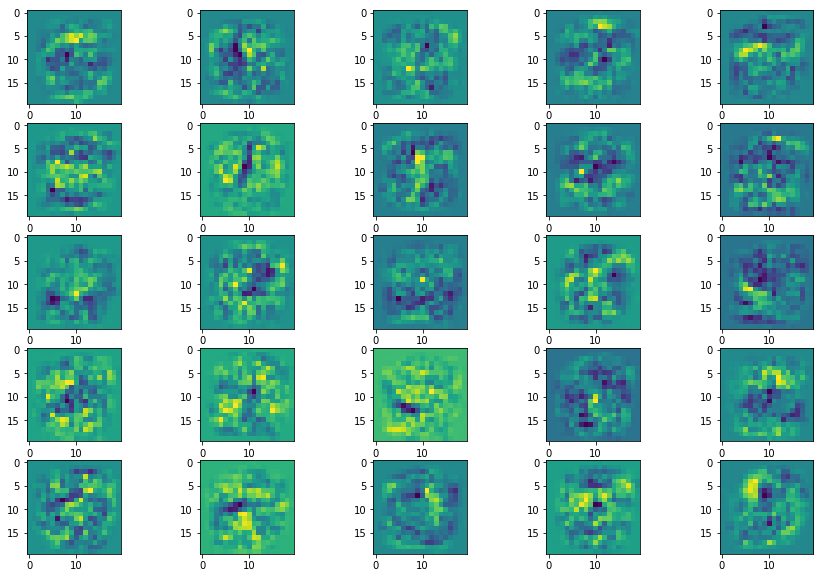

In [432]:
indicies = np.arange(theta1_res.shape[0])

cols,rows=5,5
fig, ax  = plt.subplots(rows,cols, figsize=[15,10])
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(scipy.misc.toimage(theta1_res[i*cols+j,1:].reshape(20,20).T))
plt.show()